<a href="https://colab.research.google.com/github/twanglom/EGRO-Framework/blob/main/egro_test_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Efficient Global Robust Optimization Framework**

*   (Last Updated: 21/8/2024)




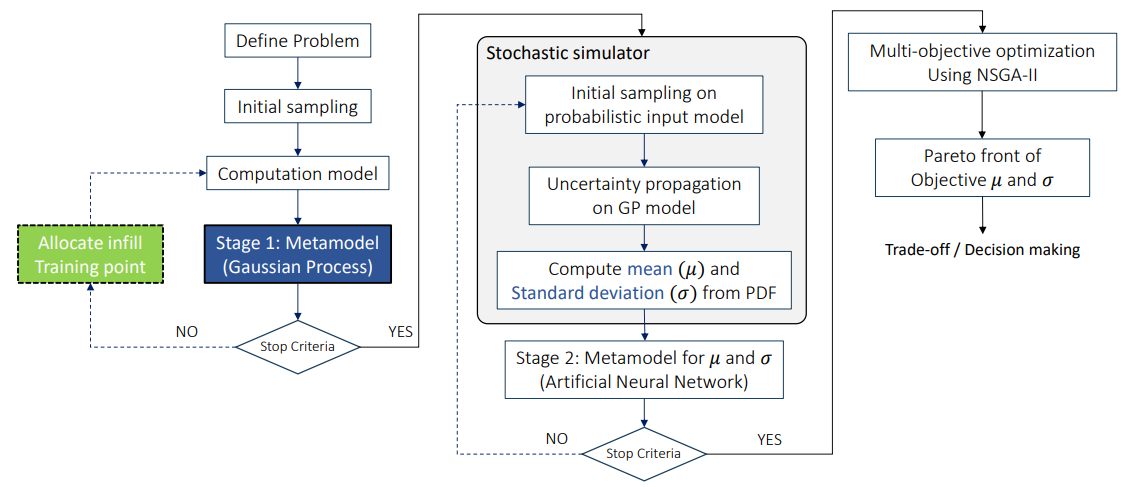




*   (Thanasak W., 2024)



**Package Requirement**

**Initial Runing Path**

In [ ]:
%cd /content/drive/MyDrive/PhD/PyTorch_LIB_TPU

/content/drive/MyDrive/PhD/PyTorch_LIB_TPU


**Verified Runtime Type**

In [ ]:
import torch
if torch.cuda.is_available():
    print("CUDA is available. GPU details:")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
    print(f"Device Memory: {torch.cuda.get_device_properties(0).total_memory / (1024 ** 3):.2f} GB")
else:
    print("CUDA is not available. Running on CPU.")


CUDA is not available. Running on CPU.


**Example Problem**

- Objective Function

The function $f(X_1, X_2)$ is defined as:

######$
f(X_1, X_2) = - \left[ A_1 \cdot \exp\left( - \left( \frac{(X_1 - c_{X_1})^2}{2s_{X_1}^2} + \frac{(X_2 - c_{X_2})^2}{2s_{X_2}^2} \right) \right) + A_2 \cdot \exp\left( - \left( \frac{(X_1 - c_{X_3})^2}{2s_{X_3}^2} + \frac{(X_2 - c_{X_4})^2}{2s_{X_4}^2} \right) \right) - 200 \right]
$

Where:

$A_1 = 100$, $ A_2 = 150 $

$c_{X_1} = 3$, $c_{X_2} = 2.1 $, $ c_{X_3} = -1.5$, $c_{X_4} = -1.2$

$s_{X_1} = s_{X_2} = 3$, $ s_{X_3} = s_{X_4} = 1 $

---

- Input Information

| Description                     | Value                  |
| --------------------------------|------------------------|
| **Design Variable**             | $X_1$, $X_2$         |
| **Design Range**                | (-5, 5), (-6, 6)       |
| **Number of Initial Samples**   | 150                     |
| - Training set                  | 100                     |
| - Validation set                | 50                     |

---

- Uncertainty Variable

| Variable   | COV  | Distribution |
|------------|------|--------------|
| $X_1 $ | 15%  | Normal       |
| $ X_2 $ | 15%  | Normal       |

---

- Deterministic Solution

Global minima:$f(X_1, X_2) = 40$ at $(X_1, X_2) = (-1, -1.5)$

Local minima: $f(X_1, X_2) = 100 $ at $(X_1, X_2) = (3, 2.1)$

---



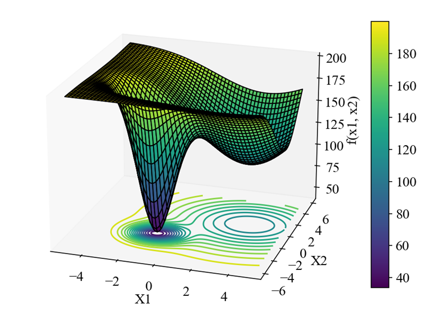

**STEP 1: Initial Design Sample and Evaluate Objective**

In [ ]:
!python step_0_initial_design.py

Training sample data saved to 'DATA_PREPARATION/training_data.csv'.
Training data calculation complete and data saved back to the file.
Testing sample data saved to 'DATA_PREPARATION/testing_data.csv'.
Testing data calculation complete and data saved back to the file.
All information data saved to data_info.json.


**STEP 2: Constructing Stage 1 Gaussian Process Regression**
- This step will demonstrate the hyperparameter optimization, model traning and validaditon by testing data set
- all result file will be saved into log data as:

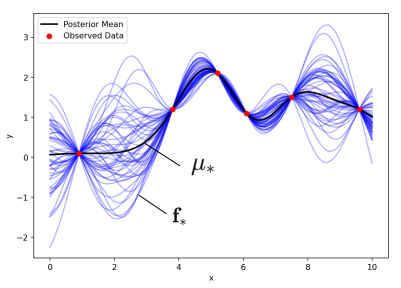







#### **GPR Model**


- **Prior Distribution (Before Observing Data)**


Given a set of training inputs $\{ x_1, x_2, \dots, x_n \}$, the function $f$ is modeled as:

$\hspace{3cm}$ $f = [f(x_1), f(x_2), \dots, f(x_n)]^T \sim \mathcal{N}(0, \mathbf{K})$

Where:
$\mathbf{K} $ is the covariance matrix generated using a kernel function $k(x, x')$

For example, with the Matérn 3/2 kernel:

$\hspace{4cm}$ $
k(x, x') = \sigma_f^2 \left( 1 + \frac{\sqrt{3} \lvert x - x' \rvert}{\ell} \right) \exp\left( -\frac{\sqrt{3} \lvert x - x' \rvert}{\ell} \right)
$

- Covariance Matrix Between Training Points

$
\mathbf{K} = \begin{bmatrix}
k(x_1, x_1) + \sigma_y^2 & k(x_1, x_2) & \dots & k(x_1, x_n) \\
k(x_2, x_1) & k(x_2, x_2) + \sigma_y^2 & \dots & k(x_2, x_n) \\
\vdots & \vdots & \ddots & \vdots \\
k(x_n, x_1) & k(x_n, x_2) & \dots & k(x_n, x_n) + \sigma_y^2
\end{bmatrix}
$

- Where hyperparameter:

$\hspace{2cm}$ $\ell$ is the length scale

$\hspace{2cm}$ $\sigma_f^2$ is the variance of the kernel (output scale)

$\hspace{2cm}$ $\sigma_y$ is the noise signal

- *We are going to sample* $f_*$ at $x_*$ *given the observed data* $Y_{train}$.

---

- **Posterior Distribution (After Observing Data)**

Given training data $X_{train}$, $Y_{train}$ and test input $x_*$, the posterior distribution for $f_*$ is given by:

$\hspace{5cm}$ $f_* \mid X, y, X_* \sim \mathcal{N}(\mu_*, \Sigma_*)$

Where:
- Mean: $\mu_* = \mathbf{K}_* \mathbf{K}^{-1} Y_{train}$
- Covariance: $\Sigma_* = \mathbf{K}_{**} - \mathbf{K}_* \mathbf{K}^{-1} \mathbf{K}_*^T$

Where:
- $\mathbf{K}_*$is the matrix of covariance between test points and training points.
- $\mathbf{K}_{**}$ is the matrix of covariance between test points.




In [ ]:
!python step_1_stage1_meta_hyperparam.py

CUDA is not available. Running on CPU.
Hyper-parameter Optimization:: 100% 1000/1000 [00:45<00:00, 21.95it/s]
best parameters: {'lengthscale': 0.006123455478907127, 'outputscale': 0.44861485764680487, 'noise': 1.005129108775624e-06}
Hyperparameter optimization completed and best parameters saved to 'RESULT_MODEL/best_params_GP.json'


In [ ]:
# Run file
!python step_1_stage1_meta_training.py

Training MSE: 3.300560146952894e-07, Test MSE: 0.35047632710220067
Training R²: 0.9999999997195254, Testing R²: 0.9997315800163223


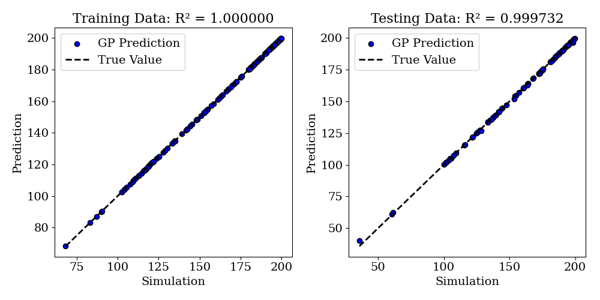

In [ ]:
from PIL import Image
from IPython.display import display
img1 = Image.open('RESULT_R2_STAGE1_METAMODEL/response_r2.png')
img1 = img1.resize((600, 300))
display(img1)


**STEP 3: Stochastic Simulator**


*   Load GPR model and the information of input range and distribution
*   Perform replication using Monte Carlo Simulation $10^6$ and $2500$ LHS samples
*   Estimate PDF, calculation μ and σ
*   Save all result in .csv file

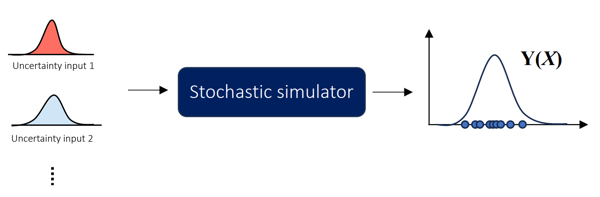



In [ ]:
!python step_2_uncertainty_propagating.py

**STEP 3: Constructing Stage 2 Multi-Layer Neural Network model**

*   This step will demonstrate the hyperparameter optimization, model traning and validaditon by testing data set

*   List item all result file will be saved into log data

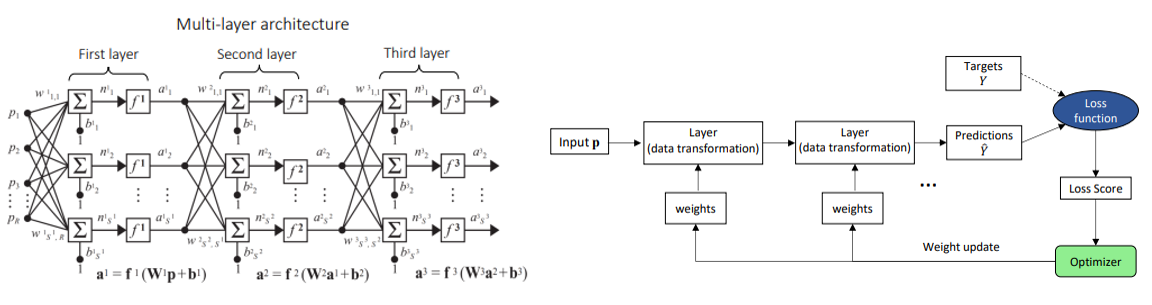


In [ ]:
!python step_3_stage2_meta_hyperparam.py

In [ ]:
!python step_3_stage2_meta_training.py

*********
Training the mean model...
*********
Training the std model...
*********
Mean Model Train R² Score: 1.0000
Mean Model Test R² Score: 1.0000
Std Model Train R² Score: 0.9986
Std Model Test R² Score: 0.9985


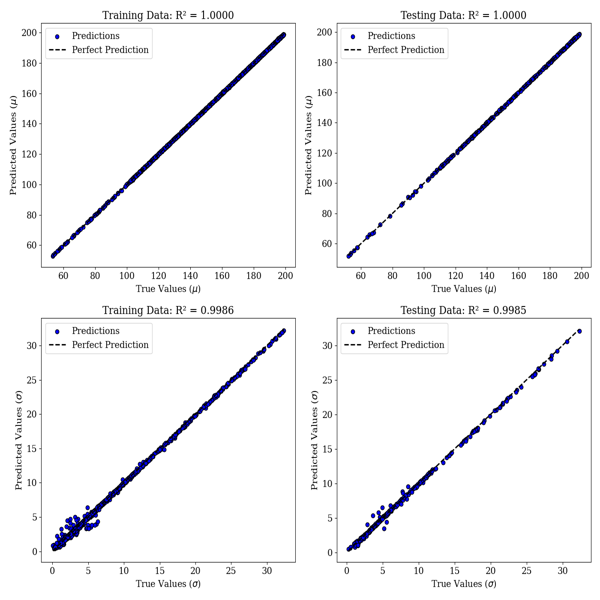

In [ ]:
from PIL import Image
from IPython.display import display
img1 = Image.open('RESULT_R2_STAGE2_METAMODEL/response_r2.png')
img1 = img1.resize((600, 600))
display(img1)


**STEP 4: Multi-Objective Optimization**

*   Finding the best trade-off solution (pareto front) using NSGA-II
*   The optimized result will be saved to log file.

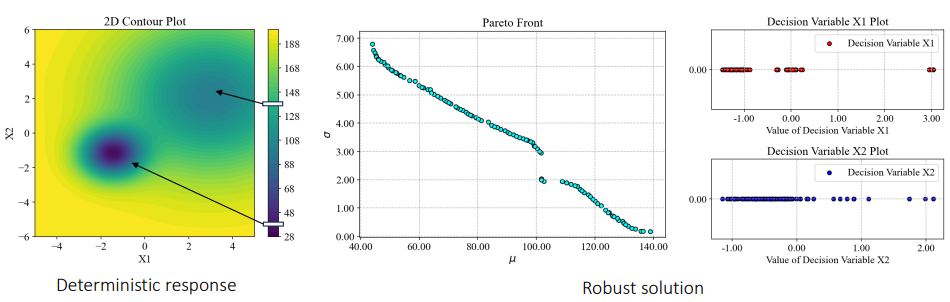

In [ ]:
!python step_4_multi_objective_optimization.py

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


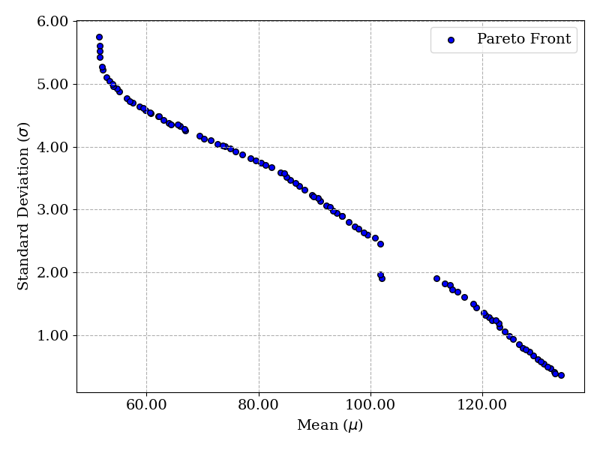

In [ ]:
from PIL import Image
from IPython.display import display
img1 = Image.open('RESULT_PARETO_FRONT/pareto_front.png')
img1 = img1.resize((600, 450))
display(img1)
